In [1]:
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load ARFF dataset
file_path = "dataset_31_credit-g.arff"
data, meta = arff.loadarff(file_path)
df = pd.DataFrame(data)

In [3]:
# Dataset Overview
print("Dataset Structure:")
print(df.info())

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing               

In [4]:
# List all the columns with missing values
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

missing_percentage = (missing_data / len(df)) * 100

missing_data_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

missing_data_df

,Missing Values,Percentage


In [5]:
# Data Overview
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

Dataset Shape: (1000, 21)

Data Types:
 checking_status            object
duration                  float64
credit_history             object
purpose                    object
credit_amount             float64
savings_status             object
employment                 object
installment_commitment    float64
personal_status            object
other_parties              object
residence_since           float64
property_magnitude         object
age                       float64
other_payment_plans        object
housing                    object
existing_credits          float64
job                        object
num_dependents            float64
own_telephone              object
foreign_worker             object
class                      object
dtype: object


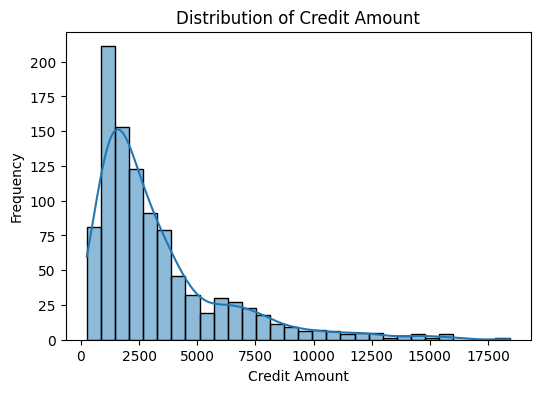

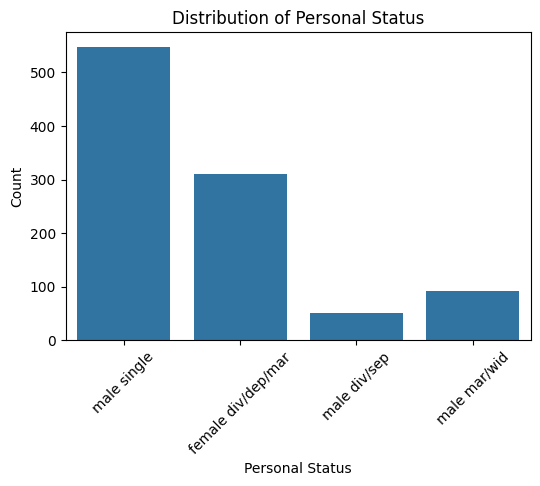

In [6]:
# Distribution of credit lines
plt.figure(figsize=(6, 4))
sns.histplot(df['credit_amount'], bins=30, kde=True)
plt.title("Distribution of Credit Amount")
plt.xlabel("Credit Amount")
plt.ylabel("Frequency")
plt.show()

# Distribution of categorical variables (Personal Status)
plt.figure(figsize=(6, 4))
sns.countplot(x=df['personal_status'])
plt.title("Distribution of Personal Status")
plt.xlabel("Personal Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [7]:
# Decode categorical variables (ARFF stores them as bytes)
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.decode("utf-8")

# Encode target variable ('good' -> 1, 'bad' -> 0)
df["class"] = df["class"].map({"good": 1, "bad": 0})

# Apply One-Hot Encoding to categorical variables (drop first category to avoid multicollinearity)
df_encoded = pd.get_dummies(df, drop_first=True)

# Handle log transformation safely (ensure no zero or negative values)
if "credit_amount" in df_encoded.columns:
    df_encoded["credit_amount"] = df_encoded["credit_amount"].apply(lambda x: max(x, 1))  # Ensure all values >=1
    df_encoded["log_credit_amount"] = np.log(df_encoded["credit_amount"])
    df_encoded.drop(columns=["credit_amount"], inplace=True)  # Remove original column

# Replace NaN values in log_credit_amount with 0 (log(1) = 0)
df_encoded["log_credit_amount"].fillna(0, inplace=True)

# Standardize numerical features
numerical_cols = ["duration", "log_credit_amount", "installment_commitment",
                  "residence_since", "age", "existing_credits", "num_dependents"]
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Define cost-based decision threshold
CUTOFF = 0.086
COST_MATRIX = np.array([[0, 1], [5, 0]])

In [8]:
# Select features for logistic regression
selected_features = ["checking_status", "duration", "credit_history", "purpose",
                     "log_credit_amount", "savings_status", "employment",
                     "installment_commitment", "personal_status", "other_parties",
                     "residence_since", "property_magnitude", "age", "other_payment_plans",
                     "housing", "existing_credits", "job", "num_dependents", "own_telephone"]

X = df_encoded.drop(columns=["class"])
y = df_encoded["class"]
X = X.loc[:, X.columns.str.startswith(tuple(selected_features))]

In [9]:
# Perform 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
base_precision, base_recall, base_f1, base_cost = [], [], [], []
rule_precision, rule_recall, rule_f1, rule_cost = [], [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train logistic regression model
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)

    # Get probability predictions
    y_prob = model.predict_proba(X_test)[:, 1]

    # Default 0.5 cutoff
    y_pred_base = (y_prob >= 0.5).astype(int)
    base_precision.append(precision_score(y_test, y_pred_base))
    base_recall.append(recall_score(y_test, y_pred_base))
    base_f1.append(f1_score(y_test, y_pred_base))
    base_cost.append(np.sum(confusion_matrix(y_test, y_pred_base) * COST_MATRIX))

    # Cost-optimized cutoff (0.086)
    y_pred_rule = (y_prob >= CUTOFF).astype(int)
    rule_precision.append(precision_score(y_test, y_pred_rule))
    rule_recall.append(recall_score(y_test, y_pred_rule))
    rule_f1.append(f1_score(y_test, y_pred_rule))
    rule_cost.append(np.sum(confusion_matrix(y_test, y_pred_rule) * COST_MATRIX))

# Store results in DataFrame
cv_baseline = pd.DataFrame({
    "base_precision": base_precision,
    "base_recall": base_recall,
    "base_f1": base_f1,
    "base_cost": base_cost,
    "rule_precision": rule_precision,
    "rule_recall": rule_recall,
    "rule_f1": rule_f1,
    "rule_cost": rule_cost
})

print("\nFinal Cross-Validation Summary:")
print(cv_baseline)

# Print final averaged results
print("\nFinal cross-validation baseline results under cost cutoff rules:")
print(f"    F1 Score: {np.mean(rule_f1):.3f}")
print(f"    Average cost per fold: {np.mean(rule_cost):.2f}")
print(f"    Precision: {np.mean(rule_precision):.3f}")
print(f"    Recall: {np.mean(rule_recall):.3f}")


Final Cross-Validation Summary:
   base_precision  base_recall   base_f1  base_cost  rule_precision  \
0        0.790123     0.907801  0.844884         99        0.708543   
1        0.805195     0.861111  0.832215        130        0.718593   
2        0.834532     0.822695  0.828571        148        0.712121   
3        0.787097     0.890511  0.835616        108        0.688442   
4        0.774194     0.875912  0.821918        120        0.685000   

   rule_recall   rule_f1  rule_cost  
0     1.000000  0.829412         58  
1     0.993056  0.833819         61  
2     1.000000  0.831858         57  
3     1.000000  0.815476         62  
4     1.000000  0.813056         63  

Final cross-validation baseline results under cost cutoff rules:
    F1 Score: 0.825
    Average cost per fold: 60.20
    Precision: 0.703
    Recall: 0.999


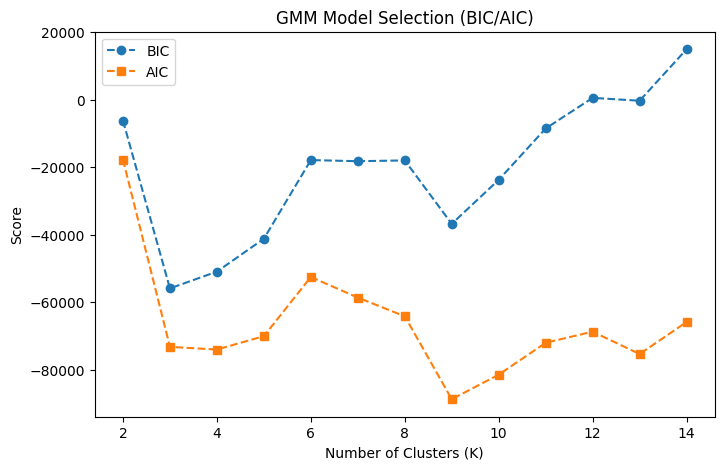

In [10]:
# Normalize data for Autoencoder input using Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Apply Min-Max Normalization

# Calculate BIC and AIC for different K values
bic_scores = []
aic_scores = []
K_range = range(2, 15)

for k in K_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

# Plot BIC/AIC to select the best K
plt.figure(figsize=(8, 5))
plt.plot(K_range, bic_scores, marker="o", linestyle="--", label="BIC")
plt.plot(K_range, aic_scores, marker="s", linestyle="--", label="AIC")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")
plt.title("GMM Model Selection (BIC/AIC)")
plt.legend()
plt.show()

In [11]:
# Set the optimal K
best_k = 3
gmm = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
gmm.fit(X_scaled)

# Get the probability that each sample belongs to different categories
gmm_probs = gmm.predict_proba(X_scaled)

# Convert to DataFrame and join original data
gmm_probs_df = pd.DataFrame(gmm_probs, columns=[f"GMM_Cluster_{i}" for i in range(best_k)])
df_encoded = df_encoded.reset_index(drop=True)
df_encoded = pd.concat([df_encoded, gmm_probs_df], axis=1)

# Count the number of customers in each category
print(df_encoded[[f"GMM_Cluster_{i}" for i in range(best_k)]].sum(axis=0))

GMM_Cluster_0    212.0
GMM_Cluster_1    167.0
GMM_Cluster_2    621.0
dtype: float64


In [12]:
y = df_encoded["class"]
X_gmm = df_encoded.drop(columns=["class"])

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
precision_gmm, recall_gmm, f1_gmm, cost_gmm = [], [], [], []

CUTOFF = 0.086
COST_MATRIX = np.array([[0, 1], [5, 0]])  # cost matrix

for train_index, test_index in kf.split(X_gmm):
    X_train, X_test = X_gmm.iloc[train_index], X_gmm.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= CUTOFF).astype(int)

    precision_gmm.append(precision_score(y_test, y_pred))
    recall_gmm.append(recall_score(y_test, y_pred))
    f1_gmm.append(f1_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    cost = np.sum(cm * COST_MATRIX)
    cost_gmm.append(cost)

# Evaluate the model
cv_results_gmm = pd.DataFrame({
    "Precision": precision_gmm,
    "Recall": recall_gmm,
    "F1-Score": f1_gmm,
    "Cost": cost_gmm
})

print("\nCross-Validation Summary for GMM + Logistic Regression:")
print(cv_results_gmm.round(3))
print("\nFinal cross-validation baseline results for GMM + Logistic Regression:")
print(f"    F1 Score: {np.mean(f1_gmm):.3f}")
print(f"    Average cost per fold: {np.mean(cost_gmm):.2f}")
print(f"    Precision: {np.mean(precision_gmm):.3f}")
print(f"    Recall: {np.mean(recall_gmm):.3f}")


Cross-Validation Summary for GMM + Logistic Regression:
   Precision  Recall  F1-Score  Cost
0      0.709   1.000     0.829   290
1      0.719   0.993     0.834   281
2      0.712   1.000     0.832   285
3      0.688   1.000     0.815   310
4      0.685   1.000     0.813   315

Final cross-validation baseline results for GMM + Logistic Regression:
    F1 Score: 0.825
    Average cost per fold: 296.20
    Precision: 0.703
    Recall: 0.999


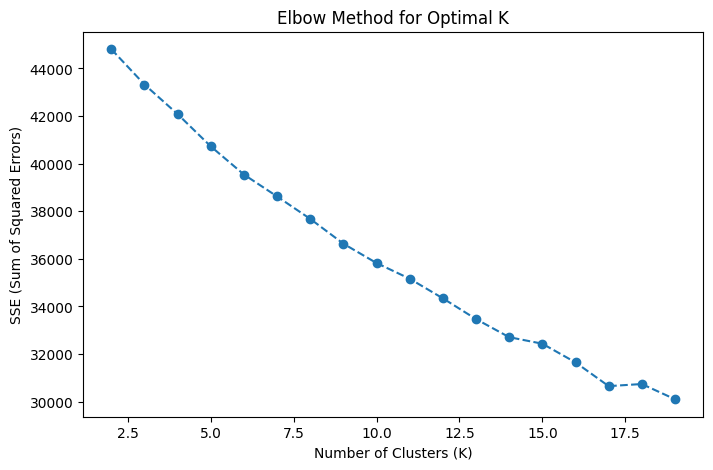

In [13]:
# Load and scale the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normalize features for clustering

### Determine the optimal number of clusters using the Elbow Method for K-Means
sse = []
K_range = range(2, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method result
plt.figure(figsize=(8, 5))
plt.plot(K_range, sse, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [14]:
# Select the optimal K (based on elbow point)
best_k = 6
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Append K-Means cluster labels as a new feature
X_kmeans = np.hstack([X_scaled, kmeans_labels.reshape(-1, 1)])
X_kmeans_df = pd.DataFrame(X_kmeans)

In [15]:
# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
precision_kmeans, recall_kmeans, f1_kmeans, cost_kmeans = [], [], [], []

CUTOFF = 0.086
COST_MATRIX = np.array([[0, 1], [5, 0]])  # cost matrix

for train_index, test_index in kf.split(X_kmeans_df):
    X_train, X_test = X_kmeans_df.iloc[train_index], X_kmeans_df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= CUTOFF).astype(int)

    precision_kmeans.append(precision_score(y_test, y_pred))
    recall_kmeans.append(recall_score(y_test, y_pred))
    f1_kmeans.append(f1_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    cost = np.sum(cm * COST_MATRIX)
    cost_kmeans.append(cost)

# Evaluate the model
cv_results_kmeans = pd.DataFrame({
    "Precision": precision_kmeans,
    "Recall": recall_kmeans,
    "F1-Score": f1_kmeans,
    "Cost": cost_kmeans
})

print("\nCross-Validation Summary for Kmeans + Logistic Regression:")
print(cv_results_kmeans.round(3))
print("\nFinal cross-validation baseline results for Kmeans + Logistic Regression:")
print(f"    F1 Score: {np.mean(f1_kmeans):.3f}")
print(f"    Average cost per fold: {np.mean(cost_kmeans):.2f}")
print(f"    Precision: {np.mean(precision_kmeans):.3f}")
print(f"    Recall: {np.mean(recall_kmeans):.3f}")


Cross-Validation Summary for Kmeans + Logistic Regression:
   Precision  Recall  F1-Score  Cost
0      0.709   1.000     0.829   290
1      0.719   0.993     0.834   281
2      0.713   0.986     0.827   282
3      0.688   1.000     0.815   310
4      0.692   1.000     0.818   305

Final cross-validation baseline results for Kmeans + Logistic Regression:
    F1 Score: 0.825
    Average cost per fold: 293.60
    Precision: 0.704
    Recall: 0.996


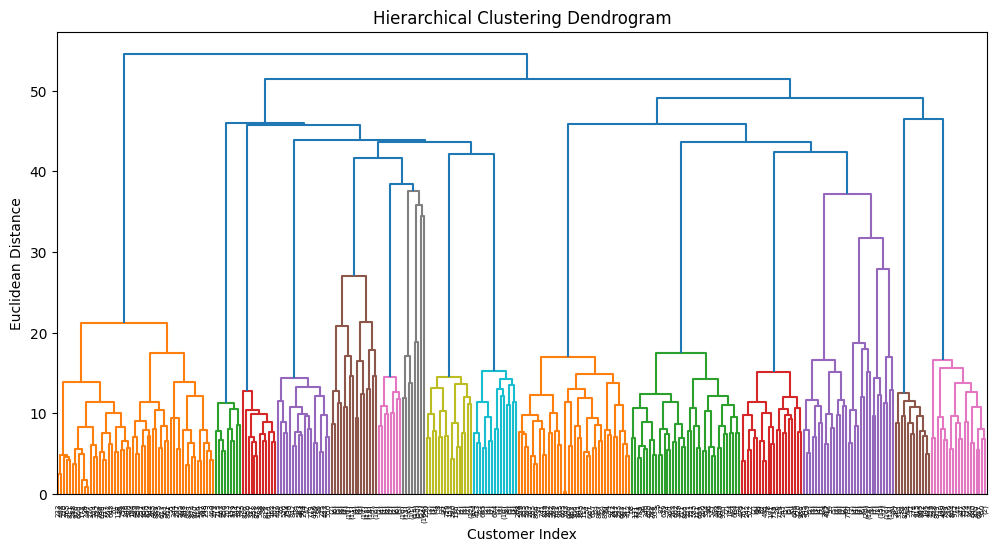

In [16]:
# Standardize Data
scaler = StandardScaler()
X_scaled_hierarchical = scaler.fit_transform(X)  # Ensure X is your preprocessed feature matrix

# Compute Linkage Matrix & Plot Dendrogram
plt.figure(figsize=(12, 6))
linkage_matrix = linkage(X_scaled_hierarchical, method="ward")
dendrogram(linkage_matrix, truncate_mode="level", p=10)  # Show top 10 cluster merges
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Customer Index")
plt.ylabel("Euclidean Distance")
plt.show()


Hierarchical Clustering Silhouette Score: 0.080


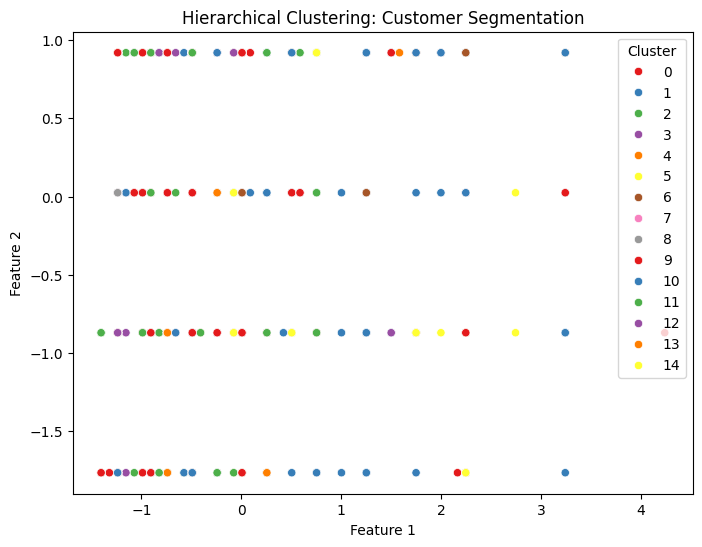

In [17]:
# Choose Number of Clusters (from Dendrogram)**
n_clusters = 15

# Apply Agglomerative Clustering**
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
hierarchical_labels = hierarchical_clustering.fit_predict(X_scaled_hierarchical)

# Evaluate Clustering Performance**
silhouette_avg = silhouette_score(X_scaled_hierarchical, hierarchical_labels)
print(f"Hierarchical Clustering Silhouette Score: {silhouette_avg:.3f}")

# Visualize Cluster Assignments (Pairplot of Two Main Features)**
X_hierarchical_df = pd.DataFrame(X_scaled_hierarchical, columns=X.columns)
X_hierarchical_df["Cluster"] = hierarchical_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_hierarchical_df.iloc[:, 0], y=X_hierarchical_df.iloc[:, 1], hue=X_hierarchical_df["Cluster"], palette="Set1")
plt.title("Hierarchical Clustering: Customer Segmentation")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster")
plt.show()

In [18]:
# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
precision_hierarchical, recall_hierarchical, f1_hierarchical, cost_hierarchical = [], [], [], []

CUTOFF = 0.086
COST_MATRIX = np.array([[0, 1], [5, 0]])  # cost matrix

for train_index, test_index in kf.split(X_hierarchical_df):
    X_train, X_test = X_hierarchical_df.iloc[train_index], X_hierarchical_df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= CUTOFF).astype(int)

    precision_hierarchical.append(precision_score(y_test, y_pred))
    recall_hierarchical.append(recall_score(y_test, y_pred))
    f1_hierarchical.append(f1_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    cost = np.sum(cm * COST_MATRIX)
    cost_hierarchical.append(cost)

# Evaluate the model
cv_results_hierarchical = pd.DataFrame({
    "Precision": precision_hierarchical,
    "Recall": recall_hierarchical,
    "F1-Score": f1_hierarchical,
    "Cost": cost_hierarchical
})

print("\nCross-Validation Summary for Hierarchical Clustering + Logistic Regression:")
print(cv_results_hierarchical.round(3))
print("\nFinal cross-validation baseline results for Hierarchical Clustering + Logistic Regression:")
print(f"    F1 Score: {np.mean(f1_hierarchical):.3f}")
print(f"    Average cost per fold: {np.mean(cost_hierarchical):.2f}")
print(f"    Precision: {np.mean(precision_hierarchical):.3f}")
print(f"    Recall: {np.mean(recall_hierarchical):.3f}")


Cross-Validation Summary for Hierarchical Clustering + Logistic Regression:
   Precision  Recall  F1-Score  Cost
0      0.709   1.000     0.829   290
1      0.720   1.000     0.837   280
2      0.714   0.993     0.831   281
3      0.688   1.000     0.815   310
4      0.692   1.000     0.818   305

Final cross-validation baseline results for Hierarchical Clustering + Logistic Regression:
    F1 Score: 0.826
    Average cost per fold: 293.20
    Precision: 0.705
    Recall: 0.999
